In [2]:
#Import packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import numpy as np
from scipy import stats
import math as m
from matplotlib import pyplot as plt
from scipy.stats import norm
#from arch import arch_model 

In [3]:
#Loading data

filename='DataLab1.csv'
table = pd.read_csv(filename)
table['Date'] = pd.to_datetime(table['Date'])
table = table.set_index('Date')
start = dt.datetime(2005, 1, 1)
end = dt.datetime(2008,12,31)
our_sample = table[start:end]
our_sample['Loss'] = our_sample['PL']*-1
print(our_sample)

              PL  Loss
Date                  
2005-01-01   190  -190
2005-01-02   190  -190
2005-01-03  -220   220
2005-01-05   120  -120
2005-01-06   450  -450
...          ...   ...
2008-12-25   500  -500
2008-12-26   300  -300
2008-12-28  -680   680
2008-12-29 -1690  1690
2008-12-31   670  -670

[1008 rows x 2 columns]


In [4]:
#1. estimating VaR/ES with rolling window of 500.


alpha = 0.99 # VaR/ES Level
sorted_losses = our_sample.sort_values('Loss', ascending=False)
#print(sorted_losses['Loss'])
our_sample['VaR'] = None
our_sample['ES'] = None
#print(our_sample)

rT = 500 #size of window 
T = 1008 #total number of points

for j in range(rT, T):
    temp_vec = our_sample['Loss'][j-rT:j] 
    sorted_losses = temp_vec.sort_values(ascending=False) #sort losses in descending order
    our_sample['VaR'][j] = sorted_losses[5] #rolling window of 500, 1% of 500 = 5 so take 6th loss (python index starts at 0)
    our_sample['ES'][j] = np.mean(sorted_losses[0:4])
    
   
print(our_sample)



              PL  Loss   VaR      ES
Date                                
2005-01-01   190  -190  None    None
2005-01-02   190  -190  None    None
2005-01-03  -220   220  None    None
2005-01-05   120  -120  None    None
2005-01-06   450  -450  None    None
...          ...   ...   ...     ...
2008-12-25   500  -500  3720  7295.0
2008-12-26   300  -300  3720  7295.0
2008-12-28  -680   680  3720  7295.0
2008-12-29 -1690  1690  3720  7295.0
2008-12-31   670  -670  3720  7295.0

[1008 rows x 4 columns]


In [5]:
#2a

my = np.mean(our_sample['Loss'][0:500])
print(my)
our_sample['UL'] = our_sample['Loss'] - my
print(our_sample)

-44.08
              PL  Loss   VaR      ES       UL
Date                                         
2005-01-01   190  -190  None    None  -145.92
2005-01-02   190  -190  None    None  -145.92
2005-01-03  -220   220  None    None   264.08
2005-01-05   120  -120  None    None   -75.92
2005-01-06   450  -450  None    None  -405.92
...          ...   ...   ...     ...      ...
2008-12-25   500  -500  3720  7295.0  -455.92
2008-12-26   300  -300  3720  7295.0  -255.92
2008-12-28  -680   680  3720  7295.0   724.08
2008-12-29 -1690  1690  3720  7295.0  1734.08
2008-12-31   670  -670  3720  7295.0  -625.92

[1008 rows x 5 columns]


In [7]:
#2b calculating volatility using EWMA

var0 = np.var(our_sample['Loss'][0:500])
our_sample['EWMA'] = None

#initial values and constants
e = 0 
sig2 = var0 #variance
eq_lambda = 0.94

#loop 
for j in range(T):
    our_sample['EWMA'][j] = (1-eq_lambda)*e**2 + eq_lambda*sig2
    e = our_sample['UL'][j]
    sig2 = our_sample['EWMA'][j]

#2c calculating vol(t) by taking square root of EWMA(t)
our_sample["vol"] = our_sample['EWMA']**0.5 
print(our_sample)

              PL  Loss   VaR      ES       UL            EWMA          vol
Date                                                                      
2005-01-01   190  -190  None    None  -145.92   117016.232384   342.076355
2005-01-02   190  -190  None    None  -145.92   111272.817225   333.575804
2005-01-03  -220   220  None    None   264.08   105874.006975   325.382862
2005-01-05   120  -120  None    None   -75.92   103705.861341   322.033944
2005-01-06   450  -450  None    None  -405.92    97829.340444   312.776822
...          ...   ...   ...     ...      ...             ...          ...
2008-12-25   500  -500  3720  7295.0  -455.92   2542989.52396  1594.675366
2008-12-26   300  -300  3720  7295.0  -255.92  2402881.935307    1550.1232
2008-12-28  -680   680  3720  7295.0   724.08  2262638.721972  1504.207008
2008-12-29 -1690  1690  3720  7295.0  1734.08  2158337.909438  1469.128282
2008-12-31   670  -670  3720  7295.0  -625.92  2209259.641656  1486.357844

[1008 rows x 7 columns]


In [11]:
#3 calculating historical losses

rows = 500
cols = 508

scaled_losses = np.zeros((rows, cols))

Losses = our_sample['Loss']
vol = our_sample['vol']


#creating loss matrix 
for j in range(rT, T):
    scaled_losses[:, j-rT] = Losses[j-rT:j]*vol[j]/vol[j-rT:j]


In [13]:
#4 ES and VaR based on historical losses (* denotes historical)

our_sample['VaR*'] = None
our_sample['ES*'] = None
#print(our_sample)

#sort historical losses and 
for j in range(508):
    temp_vec = scaled_losses[:,j]
    sorted_losses = np.sort(temp_vec)[::-1]
    our_sample['VaR*'][j + rT] = sorted_losses[5] #rolling window of 500, 1% of 500 = 5 so take 6th loss (python index starts at 0)
    our_sample['ES*'][j + rT] = np.mean(sorted_losses[0:4])

print(our_sample)

              PL  Loss   VaR      ES       UL            EWMA          vol  \
Date                                                                         
2005-01-01   190  -190  None    None  -145.92   117016.232384   342.076355   
2005-01-02   190  -190  None    None  -145.92   111272.817225   333.575804   
2005-01-03  -220   220  None    None   264.08   105874.006975   325.382862   
2005-01-05   120  -120  None    None   -75.92   103705.861341   322.033944   
2005-01-06   450  -450  None    None  -405.92    97829.340444   312.776822   
...          ...   ...   ...     ...      ...             ...          ...   
2008-12-25   500  -500  3720  7295.0  -455.92   2542989.52396  1594.675366   
2008-12-26   300  -300  3720  7295.0  -255.92  2402881.935307    1550.1232   
2008-12-28  -680   680  3720  7295.0   724.08  2262638.721972  1504.207008   
2008-12-29 -1690  1690  3720  7295.0  1734.08  2158337.909438  1469.128282   
2008-12-31   670  -670  3720  7295.0  -625.92  2209259.641656  1

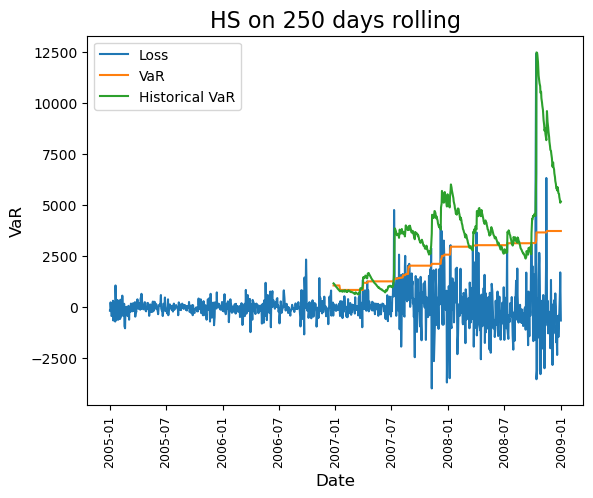

In [24]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.plot(our_sample['Loss'], label = 'Loss')
ax.plot(our_sample['VaR'], label = 'VaR')
ax.plot(our_sample['VaR*'], label = 'Historical VaR')
ax.legend()
plt.xlabel('Date',fontsize=12)
plt.ylabel('VaR',fontsize=12)
plt.title('HS on 250 days rolling',fontsize=16)
ax.tick_params(axis='x',labelrotation=90,labelsize=9)

In [25]:
#5a

#Is it normally distributed? Find out by Jarque-Bera test
print(stats.jarque_bera(our_sample['Loss']))
#No normal is not good assumption since pvalue = 0.0

SignificanceResult(statistic=46312.97820214395, pvalue=0.0)


In [28]:
#5a
print("Sample mean {:.2f}".format(np.mean(our_sample['Loss']))) 
print("Sample variance {:.2f}".format(np.var(our_sample['Loss'])))
print("Sample skewness {:.2f}".format(stats.skew(our_sample['Loss'])))
print("Sample excess kurtosis {:.2f}".format(stats.kurtosis(our_sample['Loss'], fisher = True)))

print("Similar to SP500 since it has leptokurtic (fat tails), left skewed (actually right skewed in our case but that's because we are looking at losses instead of returns).")

Sample mean 1.21
Sample variance 921497.53
Sample skewness 2.87
Sample excess kurtosis 32.71
Similar to SP500 since it has leptokurtic (fat tails), left skewed (actually right skewed in our case but that's because we are looking at losses instead of returns).


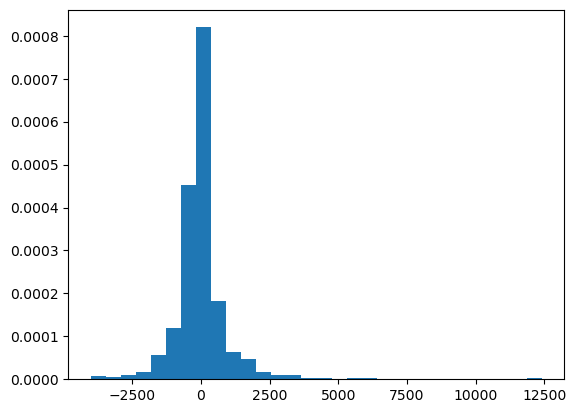

In [29]:
plt.hist(our_sample['Loss'], 30, density=True);

In [30]:
#testing t-fit function
nu,loc,scale = stats.t.fit(our_sample['Loss'])
print('nu={:.2f} loc={:.4f} and scale={:.4f}'.format(nu,loc,scale))

nu=1.47 loc=-54.3931 and scale=320.5977


In [32]:
#5b
alpha = 0.99

our_sample['VaR99_n'] = None #VaR assuming normal 
our_sample['ES99_n']  = None #ES assuming normal
our_sample['VaR99_t'] = None #VaR assuming t-distr.
our_sample['ES99_t']  = None #ES assuming t-distr.

for j in range(rT, T):
    temp_vec = our_sample['Loss'][j-rT:j]
    nu,loc,scale = stats.t.fit(temp_vec)
    mu, std = stats.norm.fit(temp_vec)

    if nu < 2:
        nu = 2.1
    
    #constants
    sig = m.sqrt(nu/(nu-2))*std
    part1 = m.sqrt((nu-2)/nu)*sig*stats.t.pdf(stats.t.ppf(alpha,nu),nu)
    part2 = 1/(1-alpha)*(nu+stats.t.ppf(alpha,nu)**2)/(nu-1)

    #VaR and ES assuming normal
    VaR99_n = stats.norm.ppf(alpha,loc=mu,scale=std) 
    ES99_n = mu+(std*1/m.sqrt(2*m.pi)*m.exp(-0.5*stats.norm.ppf(alpha)**2))/(1-alpha)

    #VaR and ES assuming T-dist
    VaR99_t = mu+m.sqrt((nu-2)/nu)*sig*stats.t.ppf(alpha,nu)
    ES99_t = mu+part1*part2 

    our_sample['VaR99_n'][j] = VaR99_n
    our_sample['ES99_n'][j]  = ES99_n
    our_sample['VaR99_t'][j] = VaR99_t
    our_sample['ES99_t'][j]  = ES99_t

In [33]:
print(our_sample)

              PL  Loss   VaR      ES       UL            EWMA          vol  \
Date                                                                         
2005-01-01   190  -190  None    None  -145.92   117016.232384   342.076355   
2005-01-02   190  -190  None    None  -145.92   111272.817225   333.575804   
2005-01-03  -220   220  None    None   264.08   105874.006975   325.382862   
2005-01-05   120  -120  None    None   -75.92   103705.861341   322.033944   
2005-01-06   450  -450  None    None  -405.92    97829.340444   312.776822   
...          ...   ...   ...     ...      ...             ...          ...   
2008-12-25   500  -500  3720  7295.0  -455.92   2542989.52396  1594.675366   
2008-12-26   300  -300  3720  7295.0  -255.92  2402881.935307    1550.1232   
2008-12-28  -680   680  3720  7295.0   724.08  2262638.721972  1504.207008   
2008-12-29 -1690  1690  3720  7295.0  1734.08  2158337.909438  1469.128282   
2008-12-31   670  -670  3720  7295.0  -625.92  2209259.641656  1

In [34]:
#6 POT method, essentially extreme value analysis

our_sample['VaR99_pot'] = None #Var using POT
our_sample['ES99_pot'] = None #ES using POT

for j in range(rT, T):
    temp_vec = our_sample['Loss'][j-rT:j]
    u = np.quantile(temp_vec,0.95)
    large_losses = temp_vec[temp_vec>u]-u #finding large losses, l > u
    (xsi,loc,beta) = stats.genpareto.fit(large_losses,floc=0) #fitting to generalized pareto distr.

    N = 500
    N_u = len(large_losses)
    #equations, see lecture notes
    middlePart = (N/N_u)*(1-alpha)
    VaR99_pot = u+(beta/xsi)*((middlePart**(-xsi))-1)
    ES99_pot = (VaR99_pot+beta-xsi*u)/(1-xsi)

    our_sample['VaR99_pot'][j] = VaR99_pot
    our_sample['ES99_pot'][j] = ES99_pot

print(our_sample)

              PL  Loss   VaR      ES       UL            EWMA          vol  \
Date                                                                         
2005-01-01   190  -190  None    None  -145.92   117016.232384   342.076355   
2005-01-02   190  -190  None    None  -145.92   111272.817225   333.575804   
2005-01-03  -220   220  None    None   264.08   105874.006975   325.382862   
2005-01-05   120  -120  None    None   -75.92   103705.861341   322.033944   
2005-01-06   450  -450  None    None  -405.92    97829.340444   312.776822   
...          ...   ...   ...     ...      ...             ...          ...   
2008-12-25   500  -500  3720  7295.0  -455.92   2542989.52396  1594.675366   
2008-12-26   300  -300  3720  7295.0  -255.92  2402881.935307    1550.1232   
2008-12-28  -680   680  3720  7295.0   724.08  2262638.721972  1504.207008   
2008-12-29 -1690  1690  3720  7295.0  1734.08  2158337.909438  1469.128282   
2008-12-31   670  -670  3720  7295.0  -625.92  2209259.641656  1

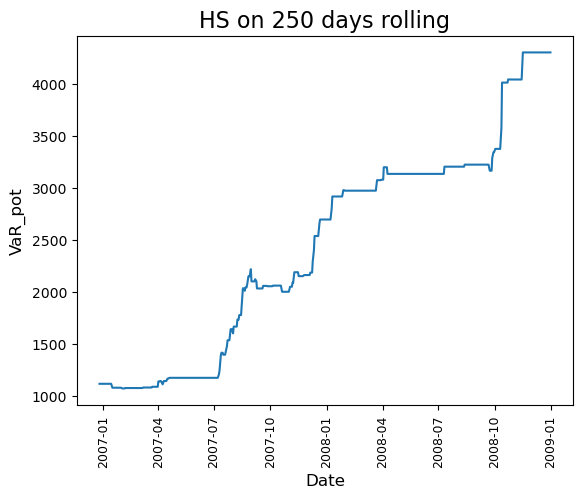

In [36]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.plot(our_sample['VaR99_pot'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('VaR_pot',fontsize=12)
plt.title('HS on 250 days rolling',fontsize=16)
ax.tick_params(axis='x',labelrotation=90,labelsize=9)